In [1]:
import numpy as np
import scipy
import matplotlib as mplt
from matplotlib import pyplot as plt
import sympy as sp
from sympy import *
from scipy.optimize import fsolve
from IPython.display import display, Latex
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets



### Setting three-body system

In [2]:
%%time
G=6.6743E-11 #SI
G=0.000118563903 #units: AU^3 M_E^(-1) yr^(-2)
G=118.4 #au^3/(M_ earth kyr^2) 

G=1.184E-4
kms_to_AUkyr=210.8 #velocity convertion to AU/Myr
kms_to_AUyr=0.2108 

dt=0.001
tmax=1000 # duration of each mass increment
time=np.arange(0,tmax,dt) #In yr
#--------------------------------------------------------------------------------------
m1=1 #Earth's mass

r1_0=np.array([0, 1, 0]) #Earth's initial position relative to CM
v1_0=np.array([-29.78*kms_to_AUyr, 0, 0]) #Earth's initial velocity

b1_0={'pos':r1_0, 'vel':v1_0, 'mass':m1}
#----------------------------------------------------------------------------------------
m2=333E+3 #Sun's mass in earth masses

r2_0=np.array([0, 0, 0]) #Sun's initial position and velocity relative to CM
v2_0=np.array([0, 0, 0])

b2_0={'pos':r2_0, 'vel':v2_0, 'mass':m2}
#----------------------------------------------------------------------------------------
m3_list=np.arange(0.02,0.12,0.01)
m3_list=[0.1]
def rot(p):
    
    p=np.deg2rad(p)
    rotation_p=[[np.cos(p), -np.sin(p), 0],
                [np.sin(p),  np.cos(p), 0],
                [        0,          0, 1]]
    return rotation_p

r_L4= np.dot(rot(60), [r1_0[0], r1_0[1], r1_0[2]])
dL4=np.array([0.0, 0.000, 0])
r3_0= r_L4 + dL4
pert=-0.0119981
v3_0= np.dot(rot(60), [v1_0[0], v1_0[1], v1_0[2]])
v3_0= (1+pert)*v3_0
#v3_0=np.array([0,0,0])
b3_0={'pos':r3_0, 'vel':v3_0, 'mass':m3_list[0]}


CPU times: total: 15.6 ms
Wall time: 18 ms


### Three-body problem gravitational acceleration calculation

In [3]:
def three_body(b1, b2, b3, G):
    r1=b1['pos']; r2=b2['pos']; r3=b3['pos'] 
    m1=b1['mass']; m2=b2['mass']; m3=b3['mass']
    
    r12= np.linalg.norm(r1-r2) #magnitude of r=r1-r2
    r13= np.linalg.norm(r1-r3)
    r23= np.linalg.norm(r2-r3)
    
    a1= -G*m2*(r1-r2)/r12**3 - G*m3*(r1-r3)/r13**3
    
    a2= -G*m1*(r2-r1)/r12**3 - G*m3*(r2-r3)/r23**3 
    
    a3= -G*m1*(r3-r1)/r13**3 - G*m2*(r3-r2)/r23**3
    
    return np.array([a1, a2, a3])

### Leapfrog for 3 bodies

In [4]:
def leapfrog_int(a, v, r, m, G, dt):
    rnew=r+v*dt+1/2*a*dt**2
    b1_lf={'pos':rnew[0], 'mass':m[0]}
    b2_lf={'pos':rnew[1], 'mass':m[1]}
    b3_lf={'pos':rnew[2], 'mass':m[2]}
    
    anew= three_body(b1_lf, b2_lf, b3_lf, G)
    
    vnew=v+1/2*(a+anew)*dt
    
    return np.array([rnew, vnew, anew])
    
    

### Numerical Solver

In [5]:
%%time
b1={'mass':m1}; b2={'mass':m2}; b3={'mass':m3_list[0]}
b1['pos']= b1_0['pos']
b2['pos']= b2_0['pos']
b3['pos']= b3_0['pos']

b1['vel']= b1_0['vel']
b2['vel']= b2_0['vel']
b3['vel']= b3_0['vel']
R_rel=np.zeros(shape=(len(m3_list)*len(time)))
r3_L4_rel=np.zeros(shape=(len(m3_list)*len(time)))
a_i_plus_1= three_body(b1, b2, b3, G)

r1_CM_traj= np.zeros(shape=(3,len(m3_list)*len(time)))
r2_CM_traj= np.zeros(shape=(3,len(m3_list)*len(time)))
r3_CM_traj= np.zeros(shape=(3,len(m3_list)*len(time)))

r_L4_traj=np.zeros(shape=(3,len(m3_list)*len(time)))
r_L4_traj[:,0]=r_L4

h1=np.zeros(shape=(len(m3_list)*len(time)))
h2=np.zeros(shape=(len(m3_list)*len(time)))

h3=np.zeros(shape=(len(m3_list)*len(time)))

V_rel=np.zeros(shape=(len(m3_list)*len(time)))

for j, m3 in enumerate(m3_list):
    for i in range(len(time)):

        if i==0 and j==0:
            r_CM= (m1*b1['pos']+m2*b2['pos']+m3*b3['pos'])/(m1+m2+m3)
            r1_CM= -b1['pos']+r_CM
            r2_CM= -b2['pos']+r_CM
            r3_CM= -b3['pos']+r_CM
            r12_CM=(m1*b1['pos']+m2*b2['pos'])/(m1+m2)
        else:
            new= leapfrog_int(a_i_plus_1, np.array([b1['vel'], b2['vel'], b3['vel']]), np.array([b1['pos'], b2['pos'], b3['pos']]), np.array([m1, m2, m3]), G, dt)
            b1['pos']= new[0][0]; b1['vel']= new[1][0]
            b2['pos']= new[0][1]; b2['vel']= new[1][1]
            b3['pos']= new[0][2]; b3['vel']= new[1][2]
            a_i_plus_1=np.array(new[2])

            r_CM=(m1*b1['pos']+m2*b2['pos']+m3*b3['pos'])/(m1+m2+m3)
            r12_CM=(m1*b1['pos']+m2*b2['pos'])/(m1+m2)
        r1_CM= -b1['pos']+r_CM
        r2_CM= -b2['pos']+r_CM
        r3_CM= -b3['pos']+r_CM

        r1_CM_traj[:,i+len(time)*j]= r1_CM
        r2_CM_traj[:,i+len(time)*j]= r2_CM
        r3_CM_traj[:,i+len(time)*j]= r3_CM
        #L4_new=(np.dot(rot(-60), [r1_CM_traj[0,i], r1_CM_traj[1,i], r1_CM_traj[2,i]]))

        R_rel[i+len(time)*j]= np.linalg.norm(r3_CM-r1_CM)
       
        L4_new=r12_CM-(np.dot(rot(60), [b1['pos'][0], b1['pos'][1], b1['pos'][2]]))
       # print(L4_new[0][i])
        r_L4_traj[:,i+len(time)*j]= np.array([L4_new[0], L4_new[1], L4_new[2]])
        r3_L4_rel[i+len(time)*j]= np.linalg.norm(r3_CM-L4_new)

        r1=[b1['pos'][0], b1['pos'][1]]
        v1=[b1['vel'][0], b1['vel'][1]]
        h1[i+len(time)*j]=np.linalg.norm(np.cross(r1,v1))

        r2=[b2['pos'][0], b2['pos'][1]]
        v2=[b2['vel'][0], b2['vel'][1]]
        h2[i+len(time)*j]=np.linalg.norm(np.cross(r2,v2))

        r3=[b3['pos'][0], b3['pos'][1]]
        v3=[b3['vel'][0], b3['vel'][1]]
        h3[i+len(time)*j]=np.linalg.norm(np.cross(r3,v3))
        
        V_rel[i+len(time)*j]= np.linalg.norm(np.matrix(v3)-np.matrix(v1))

CPU times: total: 9min 27s
Wall time: 10min 28s


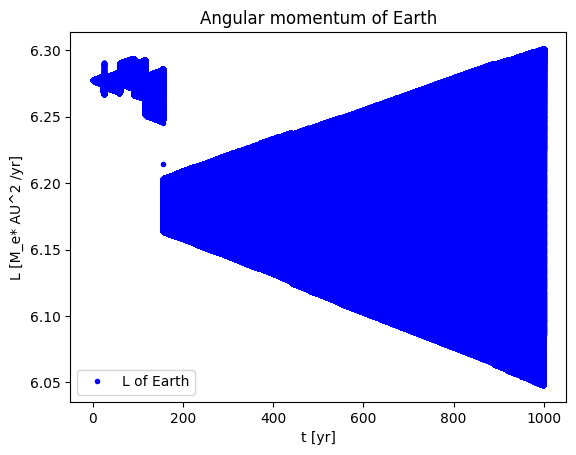

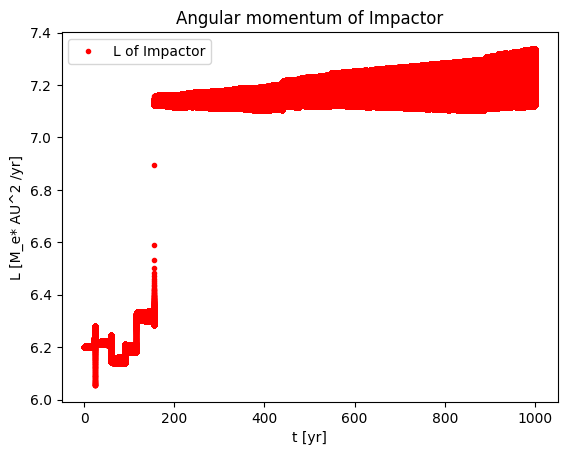

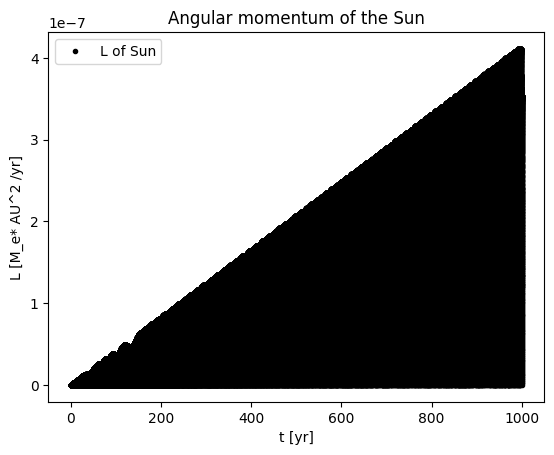

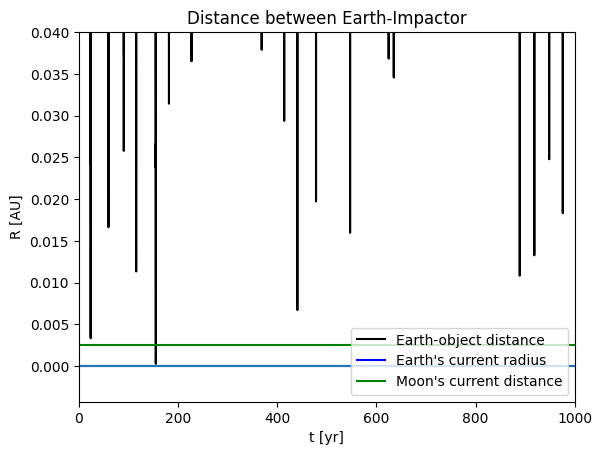

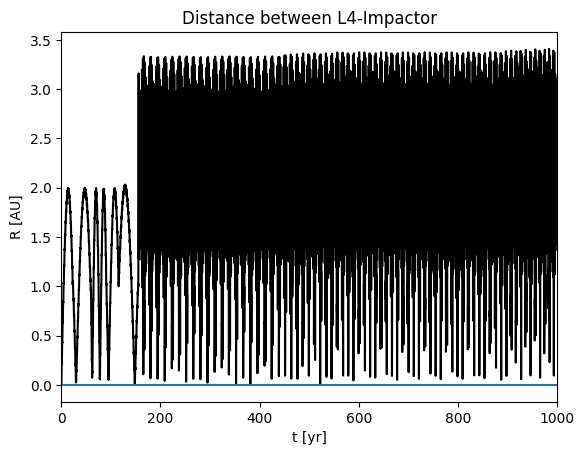

In [6]:
new_t=np.arange(0,tmax*len(m3_list),dt)
plt.plot(new_t, h1, 'b.',label='L of Earth')
plt.ylabel('L [M_e* AU^2 /yr]')
#plt.xlim([0,300])
plt.xlabel('t [yr]')
plt.title('Angular momentum of Earth')
plt.legend()
plt.show()
plt.plot(new_t, h3, 'r.', label='L of Impactor')
plt.title('Angular momentum of Impactor')

#plt.xlim([0,300])
plt.ylabel('L [M_e* AU^2 /yr]')
plt.xlabel('t [yr]')

plt.legend()
plt.show()
plt.plot(new_t, h2, 'k.', label='L of Sun')
plt.title('Angular momentum of the Sun')

#plt.xlim([0,300])
plt.xlabel('t [yr]')

plt.ylabel('L [M_e* AU^2 /yr]')

plt.legend()
plt.show()
plt.plot(new_t, R_rel,'k-',label='Earth-object distance' )
plt.axline([0,4.26352E-5], slope=0, color='b', label= "Earth's current radius")
plt.axline([0,0.0025695686589742], slope=0, color='g', label="Moon's current distance" )
plt.ylabel('R [AU]')
plt.xlabel('t [yr]')
plt.title('Distance between Earth-Impactor')
plt.axline([0,0], slope=0)
plt.ylim([-4.26352E-3,0.04])
plt.xlim([0,1000])
plt.legend()
plt.savefig('zoom_large_pert_Earth-imp')
plt.show()

plt.plot(new_t, r3_L4_rel,'k-')
#plt.axline([0,4.26352E-5], slope=0)
plt.ylabel('R [AU]')
plt.xlabel('t [yr]')
plt.title('Distance between L4-Impactor')
plt.axline([0,0], slope=0)
plt.xlim([0,1000])
plt.savefig('large_pert_L4-imp')

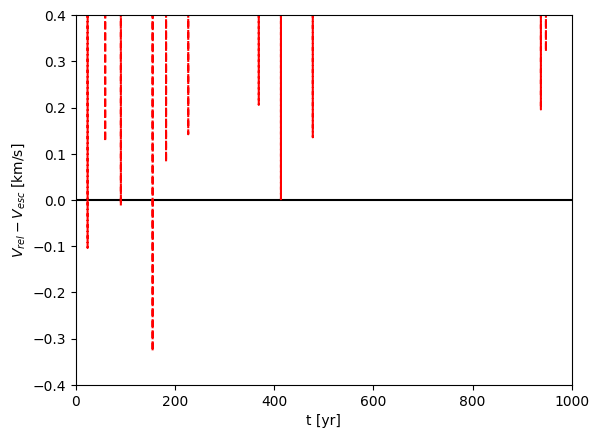

In [479]:
ve=np.sqrt(2*G*m1/R_rel)#/kms_to_AUyr
plt.axline([0,0], slope=0, color='k')
plt.plot(new_t, (V_rel-ve)/kms_to_AUyr, 'r--')
plt.ylim([-0.4,0.4])
plt.xlim([0,1000])
plt.xlabel('t [yr]')
plt.ylabel(r'$V_{rel}-V_{esc}$'+r' [km/s]')
plt.savefig('large_pert_vel')
# for i in range(len(new_t)):
#     Vesc=np.sqrt(2*G*m1/R_rel[i])
#     if V_rel[i]<=Vesc:
#         print(R_rel[i], new_t[i], (ve[i]-V_rel[i])/kms_to_AUyr)